### Imports and Settings

In [3]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pickle
import os
import matplotlib.font_manager as fm

os.makedirs("plots/plots_for_paper", exist_ok=True)

font_path = "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf"
times_font = fm.FontProperties(fname=font_path)

times_10 = times_font.copy()
times_10.set_size(10)

times_12 = times_font.copy()
times_12.set_size(12)

times_14 = times_font.copy()
times_14.set_size(14)

times_16 = times_font.copy()
times_16.set_size(16)

times_17 = times_font.copy()
times_17.set_size(17)

times_18 = times_font.copy()
times_18.set_size(18)

times_20 = times_font.copy()
times_20.set_size(20)

times_22 = times_font.copy()
times_22.set_size(22)

times_24 = times_font.copy()
times_24.set_size(24)

times_26 = times_font.copy()
times_26.set_size(26)



### Heatmaps for Probing Results per Layer and Aggregation Strategy

In [ ]:
def create_heatmap(matrix, title, blocks):
    d = {"mean": "mean", "sum": "sum", "sum_norm": "length  <br>normalized  <br>sum", "last_tok": "final token"}

    fig = go.Figure()
    
    y_labels = ["sum_norm", "sum", "mean", "last_tok"]  
    z_values =  [matrix[y] for y in y_labels]
    x_labels = [f"{i}" for i in range(0, blocks + 1)]

    # Create the heatmap
    fig.add_trace(
        go.Heatmap(
            z=z_values,
            x=x_labels,
            xgap=0.15,  # Adds gap between columns
            ygap=0.15,  # Adds gap between rows
            y=[d[yi] for yi in y_labels],
            colorscale="YlGnBu",#"YlGnBu",
            colorbar=dict(
            tickfont=dict(size=18),
            len=0.8,
            thickness=20,
            x=1.05
            ),
            hoverongaps=False,
            text=[[f"{value:.2f}" for value in row] for row in z_values],
            hovertemplate="Position: %{y}<br>Layer: %{x}<br>F1-Score: %{text}<extra></extra>",
            zmin=0,  # Set minimum value for color scale
            zmax=1,  # Set maximum value for color scale
        )
    )

    fig.add_annotation(
    text="F1-Score",
    x=1.10,
    y=1.02,
    showarrow=False,
    font=dict(size=18, color="black"),
    xref="paper",
    yref="paper"
    )

    # Add titles and labels
    fig.update_layout(
        xaxis_title=dict(text="Layers", font=dict(size=18, weight="bold")),
        yaxis_title=dict(text="Aggregation Type", font=dict(size=18, weight="bold")),
        xaxis=dict(tickfont=dict(size=14)),
        yaxis=dict(tickfont=dict(size=15),title=dict(standoff=20),
                   # Increase space between tick labels and plot
            ticklen=20,      # Length of the tick marks
            ticksuffix='  ', # Add extra space after tick labels
            side='left',
            showline=False,
            linewidth=2,
            linecolor='black',
        ),
        template="plotly_white",
    )

    fig.update_layout(
    plot_bgcolor="white",  # Background becomes visible through gaps
    paper_bgcolor="white",
)

    #
    fig.update_yaxes(
    ticklabelposition="outside left",  # Position tick labels outside the plot area
    automargin=True                    # Automatically adjust margins to accommodate labels
    )

    return fig

In [ ]:
model_name = "qwen2.5_7b_instruct"
blocks = 28
for target in ["tense", "aspect", "full_tense"]:
    with open(f"results/{model_name}/full_layer_probe_{target}.pkl", "rb") as f:
        matrix = pickle.load(f)

    fig = create_heatmap(matrix, "Probe Performance per Layer and Aggregation", blocks)
    fig.update_layout(width=1300,
    height=400,
    margin=dict(l=60, r=60, t=20, b=40),  # l=left, r=right, t=top, b=bottom
    )
    fig.show()
    fig.write_image(file=f"plots/plots_for_paper/probing_success_qwen_{target}.pdf") #, format="pdf", bbox_inches="tight")

In [ ]:
model_name = "llama3.1_8b_instruct"
blocks = 32
for target in ["tense", "aspect", "full_tense"]:
    with open(f"results/{model_name}/full_layer_probe_{target}.pkl", "rb") as f:
        matrix = pickle.load(f)

    fig = create_heatmap(matrix, "Probe Performance per Layer and Aggregation", blocks)
    fig.update_layout(width=1300,
    height=400,
    margin=dict(l=60, r=60, t=20, b=40),  # l=left, r=right, t=top, b=bottom
    )
    fig.show()
    fig.write_image(file=f"plots/plots_for_paper/probing_success_llama_{target}.pdf") #, format="pdf", bbox_inches="tight")

### Projection of Hidden States along Tense and Aspect Directions (2D Plot)

In [ ]:
# 2D LDA 
import pickle
import torch
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
from helper import load_label_info


def load_plot_data(model_name, layer):
        result_dir = f"results/{model_name}/feature_vectors/l{layer}"
        with open(f"{result_dir}/data.pkl", "rb") as f1:
            data_dict = pickle.load(f1)
        with open(f"{result_dir}/target_dirs_full.pkl", "rb") as f2:
            target_dirs = pickle.load(f2)
        return target_dirs, data_dict

def plot_two_features_2d_local(
        model_name,
        layer_idx,
    target_dirs,
    label_lookup,
    feature1a,
    feature1b,
    feature2a,
    feature2b,
    child1,
    child2,
    child3,
    child4,
    X,
    y,
    plot_dir=None,
    mode=None,
):
    scatter_size = 15
    color1 = "tab:blue"
    color2 = "mediumaquamarine"
    color3 = "firebrick"
    color4 = "darkorange"

    dir_1a = target_dirs[feature1a]["lda"]
    dir_1b = target_dirs[feature1b]["lda"]
    dir_2a = target_dirs[feature2a]["lda"]
    dir_2b = target_dirs[feature2b]["lda"]

    higher1 = dir_1a
    higher2 = dir_1b
    subcat1 = dir_2a
    subcat2 = dir_2b

    dir1 = higher2 - higher1
    dir2 = subcat2 - subcat1

    # normalize
    dir1 = dir1 / dir1.norm()
    dir2 = dir2 / dir2.norm()
    # orthogonal (not necessary it seems)
    dir1 = dir1 / dir1.norm()
    dir2 = dir2 - (dir2 @ dir1) * dir1
    dir2 = dir2 / dir2.norm()
    

    def proj(child, dir1, dir2):
        X_child = torch.tensor(X[np.isin(y, label_lookup["full_tense"][child])])
        proj1_child = X_child @ dir1
        proj2_child = X_child @ dir2
        return proj1_child, proj2_child

    proj1_child1, proj2_child1 = proj(child1, dir1, dir2)
    proj1_child2, proj2_child2 = proj(child2, dir1, dir2)
    proj1_child3, proj2_child3 = proj(child3, dir1, dir2)
    proj1_child4, proj2_child4 = proj(child4, dir1, dir2)

    proj1 = torch.tensor(X) @ dir1
    proj2 = torch.tensor(X) @ dir2

    fig = plt.plot(figsize=(25, 7))
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.hlines(
        0,
        xmax=proj1.max().cpu().numpy(),
        xmin=proj1.min().cpu().numpy(),
        colors="black",
        alpha=0.3,
        linestyles="dashed",
    )
    plt.vlines(
        0,
        ymax=proj2.max().cpu().numpy(),
        ymin=proj2.min().cpu().numpy(),
        colors="black",
        alpha=0.3,
        linestyles="dashed",
    )

    plt.scatter(
        proj1_child1.cpu().numpy(),
        proj2_child1.cpu().numpy(),
        alpha=0.93,
        color=color1,
        s=scatter_size,
    )

    plt.scatter(
        proj1_child2.cpu().numpy(),
        proj2_child2.cpu().numpy(),
        alpha=0.93,
        color=color2,
        s=scatter_size,
    )

    plt.scatter(
        proj1_child3.cpu().numpy(),
        proj2_child3.cpu().numpy(),
        alpha=0.93,
        color=color3,
        s=scatter_size,
    )

    plt.scatter(
        proj1_child4.cpu().numpy(),
        proj2_child4.cpu().numpy(),
        alpha=0.93,
        color=color4,
        s=scatter_size,
    )

    legend_handles = []
    legend_handles.append(mpatches.Patch(color=color2, label=child2.replace("_", " ")))
    legend_handles.append(mpatches.Patch(color=color1, label=child1.replace("_", " ")))
    legend_handles.append(mpatches.Patch(color=color4, label=child4.replace("_", " ")))
    legend_handles.append(mpatches.Patch(color=color3, label=child3.replace("_", " ")))

    plt.xlabel(r'$\bar{\ell}_{\mathrm{TENSE}}$', fontsize=16) #, fontweight="bold")
    plt.ylabel(r'$\bar{\ell}_{\mathrm{ASPECT}}$', fontsize=16) #, fontweight="bold")

    plt.xticks(fontproperties=times_16)
    plt.yticks(fontproperties=times_16)
    plt.locator_params(axis='y', nbins=8)    # Fewer y-ticks
    plt.locator_params(axis='x', nbins=8)    # Fewer y-ticks

    leg = plt.legend(handles=legend_handles, loc="upper right")
    for text in leg.get_texts():
        text.set_fontproperties(times_14)

    plt.title(f"{feature1a}-{feature1b} vs {feature2a}-{feature2b}", style="italic", fontproperties=times_16)

    if plot_dir:
        plt.savefig(
            f"{plot_dir}/{model_name}_L{layer_idx}_orthogonal_{mode}_{feature1a}-{feature1b}-{feature2a}-{feature2b}.pdf", format="pdf", bbox_inches="tight"
        )
        plt.close()
    else:
        plt.show()

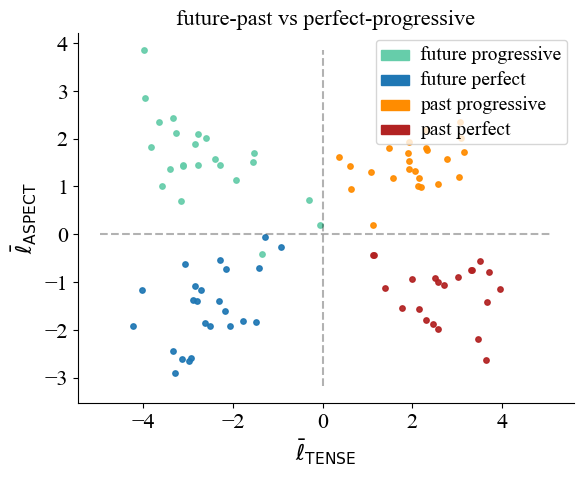

In [14]:
def plot_layer(model_name, layer_idx):

    target_dirs, data_dict = load_plot_data(model_name, layer_idx)

    plot_two_features_2d_local(model_name, layer_idx,
                            target_dirs, 
                            label_lookup, 
                           "future", 
                           "past", 
                           "perfect", 
                           "progressive", 
                           "future_perfect", 
                           "future_progressive", 
                           "past_perfect", 
                           "past_progressive", 
                           
                           data_dict["X_test"], 
                           data_dict["y_test"], 
                           mode="test", 
                           #plot_dir="plots/plots_for_paper",
                           )

label_info = load_label_info()
label_lookup = label_info["label_lookup"]

model_name = "llama3.1_8b_instruct"

plot_layer(model_name, layer_idx=7)

### Cosine Similarity between Tense & Aspect Directions

In [ ]:
import pickle
import numpy as np

def get_cs(A, B):
    cos_sim = np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))
    return cos_sim

with open(f"results/llama3.1_8b_instruct/feature_vectors/l7/target_dirs.pkl", "rb") as f1:
    sv_llama_l7 = pickle.load(f1)

tense_vec = sv_llama_l7["future"]["lda"] - sv_llama_l7["past"]["lda"]
aspect_vec = sv_llama_l7["progressive"]["lda"] - sv_llama_l7["perfect"]["lda"]

get_cs(tense_vec, aspect_vec)

### Projection of Hidden States along Tense or Aspect Directions (3D Plot)

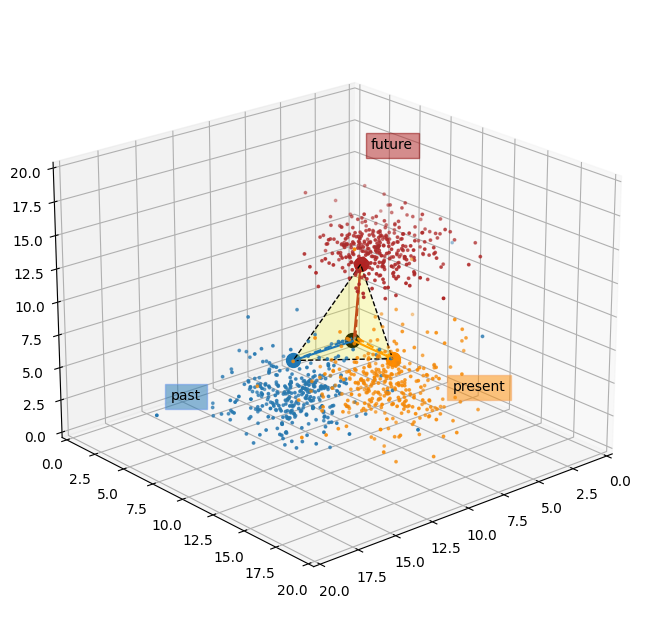

In [ ]:
from projection_plots_3d import plot_3d_categories_tenses
import pickle
from helper import load_label_info


label_info = load_label_info()
label_lookup = label_info["label_lookup"]

layer_idx = 0
model_name = "qwen2.5_7b_instruct"

def load_plot_data(model_name, layer):
        result_dir = f"results/{model_name}/feature_vectors/l{layer}"
        with open(f"{result_dir}/data.pkl", "rb") as f1:
            data_dict = pickle.load(f1)
        with open(f"{result_dir}/target_dirs.pkl", "rb") as f2:
            target_dirs = pickle.load(f2)
        return target_dirs, data_dict

target_dirs, data_dict = load_plot_data(model_name, layer_idx)

plot_3d_categories_tenses(
    target_dirs,
    label_lookup,
    data_dict["X_test"],
    data_dict["y_test"],
    vis_num=None,
    x_min=0,
    x_max=20,
    y_min=0,
    y_max=20,
    z_min=0,
    z_max=20,
    elev=21.6,
    azim=49.2,
    scale=2.5,
    model_name=model_name,
    layer_idx=layer_idx,
    #plot_dir="plots/plots_for_paper",
)

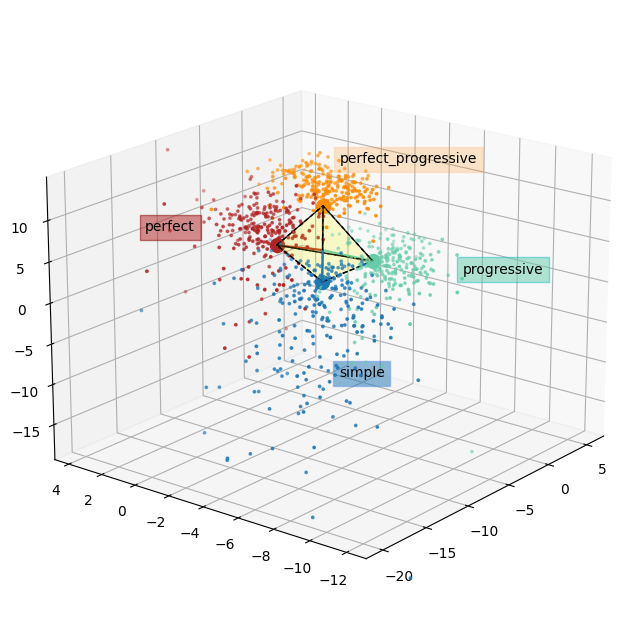

In [ ]:
layer_idx = 0
model_name = "qwen2.5_7b_instruct"

target_dirs, data_dict = load_plot_data(model_name, layer_idx)

plot_3d_categories_aspect(
    target_dirs,
    label_lookup,
    data_dict["X_test"],
    data_dict["y_test"],
    vis_num=None,
    x_min=-21.3,
    x_max=6.7,
    y_min=-12.7,
    y_max=4.5,
    z_min=-18.7,
    z_max=14.5,
    elev=19.5,
    azim=-141.6,
    scale=4,
    model_name=model_name,
    layer_idx=layer_idx,
    #plot_dir="plots/plots_for_paper",
)

### Cluster Quality Metrics

In [ ]:
import torch
import pickle
from sklearn.metrics import silhouette_score

def explained_between_class_variance(X, y, class_dirs, class_labels, label_lookup, target):
    """
    X: torch.Tensor (n_samples, d)
    y: array-like of labels
    class_dirs: dict[label] = torch.Tensor (d,)
    class_labels: list of class labels)
    """
    # Stack directions into matrix (3, d)
    V = torch.stack([class_dirs[lab] for lab in class_labels])  # (3, d)
    V = V / V.norm(dim=1, keepdim=True)  # normalize

    # Project all embeddings into 3D space (n, 3)
    X_proj = torch.from_numpy(X) @ V.T  # (n_samples, 3)
    X_proj = X_proj.numpy()
    y = np.array(y)

    # Compute total variance in subspace
    overall_mean = X_proj.mean(axis=0)
    total_var = ((X_proj - overall_mean)**2).sum()

    # Compute between-class variance
    between_var = 0.0
    for lab in class_labels:
        labels = label_lookup[target][lab]
        class_points = X_proj[np.isin(y,labels)]
        n = len(class_points)
        class_mean = class_points.mean(axis=0)
        between_var += n * np.sum((class_mean - overall_mean)**2)

    return float(between_var / total_var)

def silhouette_separation_score(X_proj, y, label_lookup, target):
    """
    Compute silhouette score in projected space.
    Values closer to 1 indicate better separation.
    """
    # Create numeric labels
    y_numeric = np.zeros(len(y))
    for i, (class_value, numeric_labels) in enumerate(label_lookup[target].items()):
        mask = np.isin(y, numeric_labels)
        y_numeric[mask] = i
    
    return silhouette_score(X_proj, y_numeric)

def fisher_like_ratio_in_subspace(X_proj, y, label_lookup, target):
    """
    Compute Fisher-like ratio specifically in 3D projected subspace.
    This measures how well the chosen directions separate the classes.
    """
    target_labels = list(label_lookup[target].keys())
    
    # Overall mean in projected space
    overall_mean = X_proj.mean(axis=0)
    
    # Between-class scatter
    between_class_scatter = 0.0
    within_class_scatter = 0.0
    
    for class_value in target_labels:
        numeric_labels = label_lookup[target][class_value]
        mask = np.isin(y, numeric_labels)
        class_points = X_proj[mask]
        
        if len(class_points) == 0:
            continue
        
        n_k = len(class_points)
        class_mean = class_points.mean(axis=0)
        
        # Between-class contribution
        between_class_scatter += n_k * np.sum((class_mean - overall_mean)**2)
        
        # Within-class contribution
        for point in class_points:
            within_class_scatter += np.sum((point - class_mean)**2)
    
    # Return ratio
    return between_class_scatter / (within_class_scatter + 1e-8)


def evaluate_class_directions(model_name, layer, target="tense"):
    """
    Evaluate how well the LDA directions separate classes.
    """
    result_dir = f"results/{model_name}/feature_vectors/l{layer}"
    with open(f"{result_dir}/data.pkl", "rb") as f1:
        data_dict = pickle.load(f1)
    X = data_dict["X_test"]
    y = data_dict["y_test"]

    with open(f"{result_dir}/target_dirs.pkl", "rb") as f2:
        target_dirs = pickle.load(f2)

    label_lookup = {"tense": {"future": [0,1,2,3],
                          "present": [4,5,6,7],
                          "past": [8,9,10,11]},
                "aspect": {"simple": [0,4,8],
                            "progressive": [1,5,9],
                            "perfect": [2,6,10],
                            "perfect_progressive": [3,7,11]}}


    if target == "tense":
        class_dirs = {"present": target_dirs["present"]["lda"],
        "past": target_dirs["past"]["lda"],
        "future": target_dirs["future"]["lda"]
        }
        class_labels=["present","past","future"]

        # Create orthogonal projection matrix
        dir1 = target_dirs["past"]["lda"]
        dir2 = target_dirs["present"]["lda"] 
        dir3 = target_dirs["future"]["lda"]
        
        xaxis = dir1 / dir1.norm()
        yaxis = dir2 - (dir2 @ xaxis) * xaxis
        yaxis = yaxis / yaxis.norm()
        zaxis = dir3 - (dir3 @ xaxis) * xaxis - (dir3 @ yaxis) * yaxis
        zaxis = zaxis / zaxis.norm()
        
        axes = torch.stack([xaxis, yaxis, zaxis], dim=1)
    elif target == "aspect":
        class_dirs = {"simple": target_dirs["simple"]["lda"],
        "perfect": target_dirs["perfect"]["lda"],
        "progressive": target_dirs["progressive"]["lda"],
        "perfect_progressive": target_dirs["perfect_progressive"]["lda"]
        }
        class_labels=["simple","perfect","progressive","perfect_progressive"]

        # Create orthogonal projection matrix
        dir1 = target_dirs["simple"]["lda"]
        dir2 = target_dirs["progressive"]["lda"]
        dir3 = target_dirs["perfect"]["lda"]
        dir4 = target_dirs["perfect_progressive"]["lda"]

        # Calculate the axes
        xaxis = (dir2 - dir1) / (dir2 - dir1).norm()
        yaxis = dir3 - dir1 - (dir3 - dir1) @ xaxis * xaxis
        yaxis = yaxis / yaxis.norm()
        zaxis = (
            (dir4 - dir1) - (dir4 - dir1) @ xaxis * xaxis - (dir4 - dir1) @ yaxis * yaxis
        )
        zaxis = zaxis / zaxis.norm()
        axes = torch.stack([xaxis, yaxis, zaxis], dim=1)
    
    # Project data
    X_proj = (torch.tensor(X) @ axes).numpy()

    metrics = {}
    
    # Silhouette score (closer to 1 = better)
    metrics['silhouette_score'] = silhouette_separation_score(X_proj, y, label_lookup, target)
    metrics['fisher_ratio_subspace'] = fisher_like_ratio_in_subspace(X_proj, y, label_lookup, target)
    metrics['explained_variance'] = explained_between_class_variance(X, y, class_dirs, class_labels, label_lookup, target)
    return metrics

model_name = "qwen2.5_7b_instruct"
layer = 0
metrics_tense = evaluate_class_directions(model_name, layer, target="tense")
metrics_aspect = evaluate_class_directions(model_name, layer, target="aspect")
metrics_tense, metrics_aspect

### Barplots for Steering Results Across Tasks

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.font_manager as fm

steering_res = pd.read_csv("SteeringResults.csv", delimiter=";")
steering_res = steering_res[~steering_res["Model"].isna()]
df_filtered = steering_res.dropna(subset=['SR (filtered, strict)'])

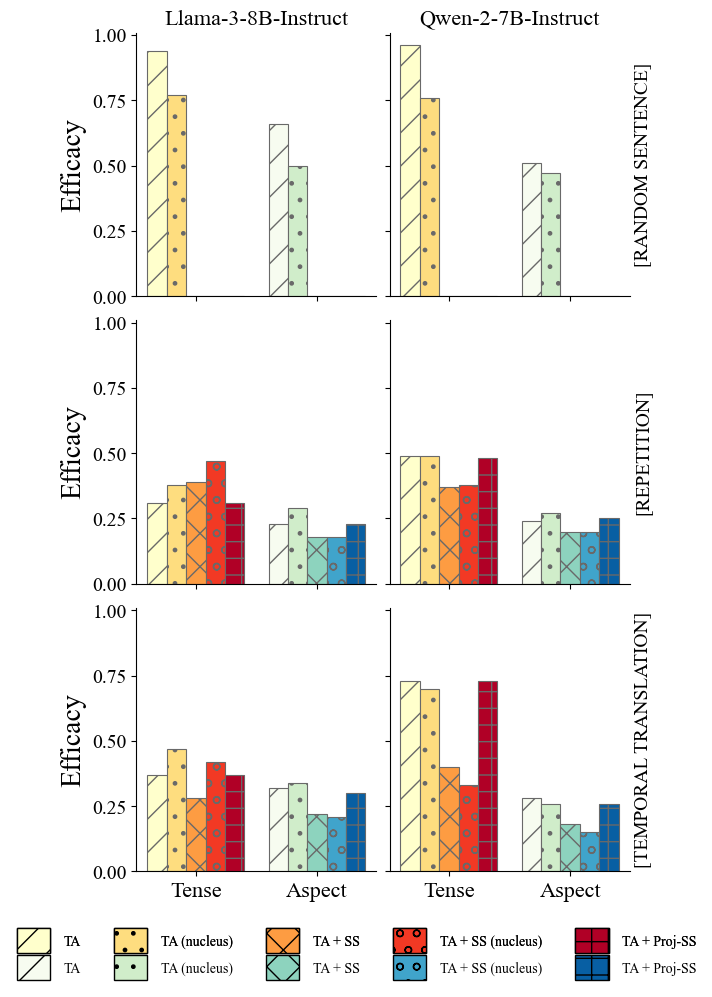

In [ ]:
models = df_filtered['Model'].unique()
tasks = ['Random', 'Repetition', 'Translate']
targets = df_filtered['Target'].unique()
methods = df_filtered['Steering Type'].unique()

model_map = {"Llama":"Llama-3-8B-Instruct",
             "Qwen": "Qwen-2-7B-Instruct"}

task_map = {"Random": "[RANDOM SENTENCE]", "Repetition": "[REPETITION]", "Translate": "[TEMPORAL TRANSLATION]"}

method_map = {"Fixed": "TA",
              "subtract": "TA + SS",
              "Fixed_nongreedy": "TA (nucleus)",
              "subtract_nongreedy": "TA + SS (nucleus)",
              "subtract_proj": "TA + Proj-SS"}

# Color maps
cmap_tense = plt.cm.YlOrRd
cmap_aspect = plt.cm.GnBu

start, end = 0, 0.9
colors_tense = [cmap_tense(start + (end - start) * (i / (len(methods) - 1))) for i in range(len(methods))]
colors_aspect = [cmap_aspect(start + (end - start) * (i / (len(methods) - 1))) for i in range(len(methods))]

task_color_map = {"Random": "tab:blue",
                  "Repetition": "firebrick",
                  "Translate": "darkorange"}
task_color_edge_map = {"Random": "cornflowerblue",
                  "Repetition": "darkred",
                  "Translate": "sandybrown"}


# Hatch patterns
hatch_patterns = ['/', '.', 'x', 'o','+']
method_hatches = {m: hatch_patterns[i % len(hatch_patterns)] for i, m in enumerate(methods)}

# Grid: rows = tasks, cols = models
n_rows, n_cols = len(tasks), len(models)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows),
                         sharey=True, constrained_layout=True)

total_width = 0.8
bar_width = total_width / len(methods)
offsets = [(-total_width/2) + k*bar_width + bar_width/2 for k in range(len(methods))]

for i, task in enumerate(tasks):
    for j, model in enumerate(models):
        ax = axes[i, j] if n_rows > 1 and n_cols > 1 else (
             axes[j] if n_rows == 1 else axes[i])
        data = df_filtered[(df_filtered['Model']==model) & (df_filtered['Task']==task)]
        x = range(len(targets))

        for k, method in enumerate(methods):
            vals = []
            for t in targets:
                subset = data[(data['Steering Type']==method)&(data['Target']==t)]
                vals.append(subset['SR (filtered, strict)'].iloc[0] if not subset.empty else 0)
            pos = [xi + offsets[k] for xi in x]
            colors = [colors_tense[k] if t=='Tense' else colors_aspect[k] for t in targets]
            ax.bar(pos, vals, bar_width,
                   color=colors, 
                   edgecolor='dimgrey',
                   hatch=method_hatches[method], 
                   linewidth=0.8)

        # Only set x-labels on the bottom row
        if i == n_rows - 1:
            ax.set_xticks(x)
            ax.set_xticklabels([t.capitalize() for t in targets], fontproperties=times_16)
        else:
            ax.set_xticks(x)
            ax.set_xticklabels([])

        # Y-label only on first column
        if j == 0:
            ax.set_ylabel("Efficacy", fontdict={"fontsize":20}, fontproperties=times_20) #,"fontweight":"bold"})
            ax.tick_params(axis='y', labelsize=14)  # Larger y-tick labels
            ax.locator_params(axis='y', nbins=5)    # Fewer y-ticks

            for label in ax.get_yticklabels():
                label.set_fontproperties(times_14)
        # Column titles: model names at top
        if i == 0:
            ax.set_title(model_map[model], fontproperties=times_16)

        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Row labels: task names on the right of each row
    # Position in figure coords: x=1.02, y=center of that row
    row_ax = axes[i, -1]
    row_ax.text(1.02, 0.5, task_map[task], va='center', ha='left',
                rotation=90, transform=row_ax.transAxes, fontproperties=times_14) #, fontweight="bold")
# 1) Tense legend: one handle per method, colored by colors_tense
tense_handles = [
    Patch(facecolor=colors_tense[k],
          edgecolor='black',
          hatch=method_hatches[method],
          label=method_map[method])
    for k, method in enumerate(methods)
]
leg_tense = fig.legend(
    handles=tense_handles,
    ncol=5,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.07),
    frameon=False,
    handleheight=2,  # Increase vertical size
    handlelength=2,  # Increase horizontal size
    fontsize='large',
    #fontproperties=times_font
)

# 2) Aspect legend: one handle per method, colored by colors_aspect
aspect_handles = [
    Patch(facecolor=colors_aspect[k],
          edgecolor='black',
          hatch=method_hatches[method],
          label=method_map[method])
    for k, method in enumerate(methods)
]
leg_aspect = fig.legend(
    handles=aspect_handles,
    ncol=5,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.10),
    frameon=False,
    handleheight=2,  # Increase vertical size
    handlelength=2,  # Increase horizontal size
    fontsize='large',
)

for text in leg_aspect.get_texts():
    text.set_fontproperties(times_10)
for text in leg_tense.get_texts():
    text.set_fontproperties(times_10)

# Make sure both draw
fig.add_artist(leg_tense)

plt.show()
fig.savefig("plots/plots_for_paper/steering_success_all.pdf", format="pdf", bbox_inches="tight")

### Impact of Steering Strategy on Selectivity

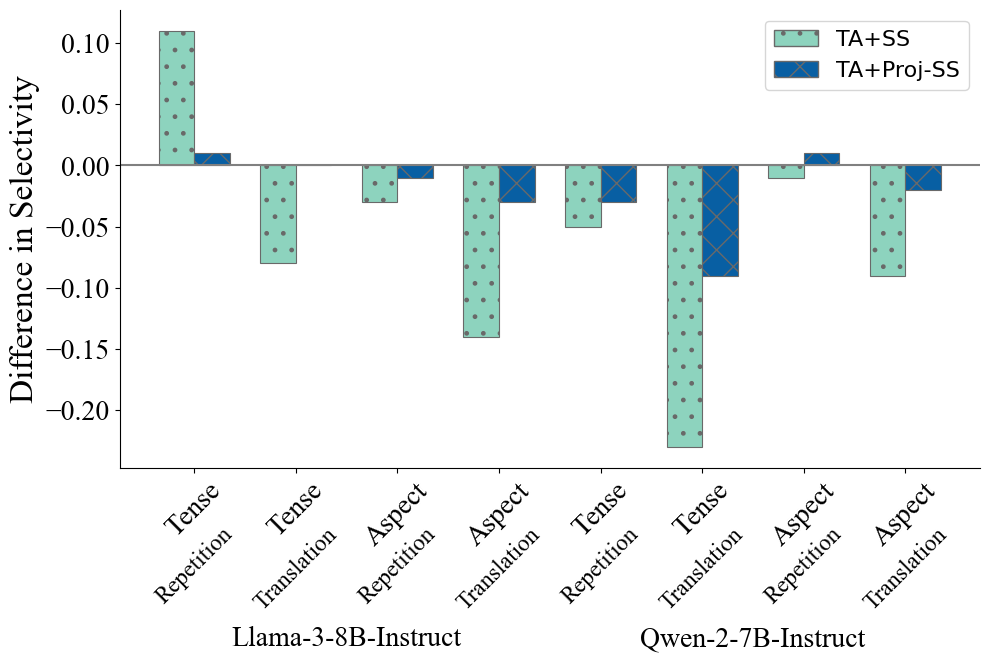

In [8]:
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

with open("few_shot_metrics.json", "r") as f:
    fs_metrics = json.load(f)

data = fs_metrics["selectivity"]

models = ['llama', 'qwen']
categories = ['Tense', 'Aspect']
tasks = ["Repetition", "Translation"]

labels = []
bar1 = []  # Add - Subtract
bar2 = []  # Add - Subtract Proj
group_labels_model = []
group_labels_task = []

for model in models:
    for category in categories:
        for task in tasks:
            labels.append(f"{category}")
            group_labels_model.append(model.capitalize())
            group_labels_task.append(task)
            
            add_val = data[model][category]['Add'][task]
            sub_val = data[model][category]['Subtract'][task]
            sub_proj_val = data[model][category]['Subtract Proj'][task]
            
            bar1.append(-(add_val - sub_val))
            bar2.append(-(add_val - sub_proj_val))

# Plot
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

cmap_tense = plt.cm.YlOrRd
cmap_aspect = plt.cm.GnBu
start, end = 0, 0.9
colors_tense = [cmap_tense(start + (end - start) * (i / (5 - 1))) for i in range(5)]
colors_aspect = [cmap_aspect(start + (end - start) * (i / (5 - 1))) for i in range(5)]
colors = {
    "TA+SS": colors_aspect[2],
    "TA+Proj-SS": colors_aspect[4],
}
hatches = {
    "TA+SS": ".",
   "TA+Proj-SS": "x",
}

bars1 = []
bars2 = []
for i in range(len(labels)):
    # Bar1 (TA+SS)
    b1 = ax.bar(
        x[i] - width/2,
        bar1[i],
        width,
        color=colors["TA+SS"],
        hatch=hatches["TA+SS"],
        edgecolor="dimgrey",
        linewidth=0.8,
        label=None  # we'll handle legend separately
    )

    bars1.append(b1)
    # Bar2 (TA+Proj-SS)
    b2 = ax.bar(
        x[i] + width/2,
        bar2[i],
        width,
        color=colors["TA+Proj-SS"],
        hatch=hatches["TA+Proj-SS"],
        edgecolor="dimgrey",
        linewidth=0.8,
        label=None
    )
    bars2.append(b2)

legend_elements = [
    Patch(facecolor=colors["TA+SS"], hatch=hatches["TA+SS"], edgecolor="dimgrey", label="TA+SS"),
    Patch(facecolor=colors["TA+Proj-SS"], hatch=hatches["TA+Proj-SS"], edgecolor="dimgrey", label="TA+Proj-SS"),
]

leg = ax.legend(handles=legend_elements, fontsize=16)

# Axis labels
ax.set_ylabel('Difference in Selectivity', fontproperties=times_24)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontproperties=times_20, rotation=45)

# Add second-level x-axis annotations (Task)
for idx, label in enumerate(group_labels_task):
    ax.text(x[idx], -0.12, label, ha='center', va='top', rotation=45, fontproperties=times_17, transform=ax.get_xaxis_transform())

# Add third-level x-axis annotations (Model)
model_positions = {
    'Llama': (1.5, 'Llama-3-8B-Instruct'),
    'Qwen': (5.5, 'Qwen-2-7B-Instruct')
}
for pos, name in model_positions.values():
    ax.text(pos, -0.345, name, ha='center', va='top', fontproperties=times_20, transform=ax.get_xaxis_transform())

# Grid
#ax.grid(False, axis='y', linestyle='--', alpha=0.7)
ax.axhline(0, color='gray', linewidth=1.5, linestyle='-')
plt.yticks(fontproperties=times_20)
plt.tight_layout()
plt.show()
#fig.savefig("plots/plots_for_paper/selectivity_per_steering.pdf")

### Correlation Between Steering Efficacy and Selectivity

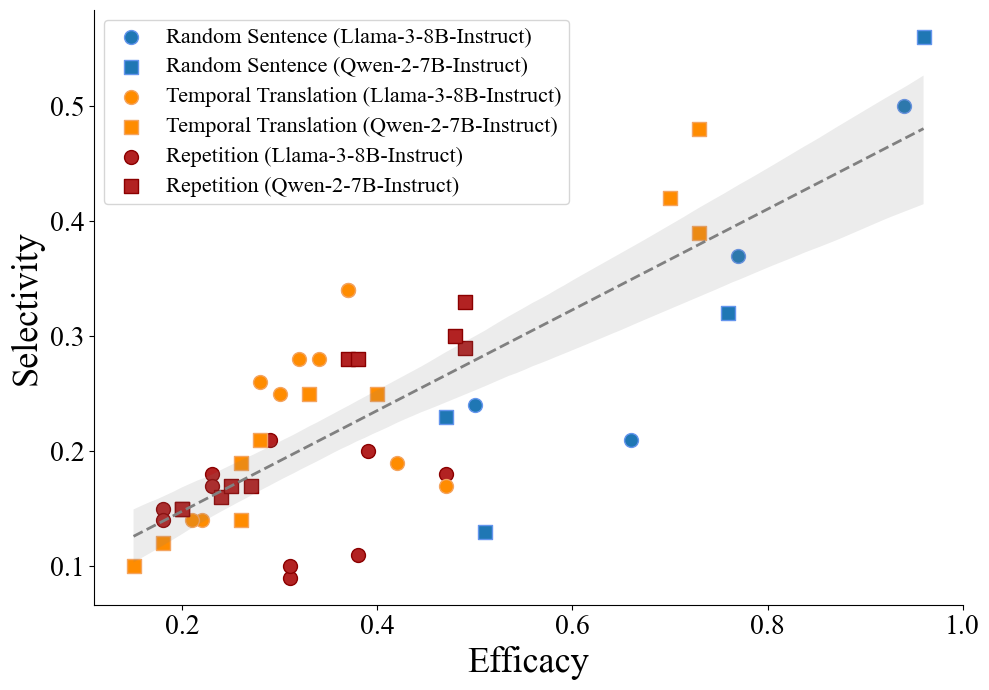

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


models = df_filtered['Model'].unique()
tasks = ['Random', 'Repetition', 'Translate']
targets = df_filtered['Target'].unique()
methods = df_filtered['Steering Type'].unique()

model_map = {"Llama":"LlAMA-3-8B",
             "Qwen": "Qwen-2-7b"}

task_map = {"Random": "Random Sentence", "Repetition": "Repetition", "Translate": "Temporal Translation"}

method_map = {"Fixed": "TA",
              "subtract": "TA + SS",
              "Fixed_nongreedy": "TA (nucleus)",
              "subtract_nongreedy": "TA + SS (nucleus)",
              "subtract_proj": "TA + Proj-SS"}

# Color maps
cmap_tense = plt.cm.YlOrRd
cmap_aspect = plt.cm.GnBu
colors_tense = [cmap_tense(i/(len(methods)-1)) for i in range(len(methods))]
colors_aspect = [cmap_aspect(i/(len(methods)-1)) for i in range(len(methods))]

# Define unique styles
model_shapes = ['o', 's', 'D', '^', 'v', '<', '>']  # Add more if needed
model_shape_map = {model: shape for model, shape in zip(df_filtered['Model'].unique(), model_shapes)}

# Define color palette for tasks
task_color_map = {"Random": "tab:blue",
                  "Repetition": "firebrick",
                  "Translate": "darkorange"}
task_color_edge_map = {"Random": "cornflowerblue",
                  "Repetition": "darkred",
                  "Translate": "sandybrown"}


fig = plt.figure(figsize=(10, 7))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot each point manually
for idx, row in df_filtered.iterrows():
    model = row['Model']
    task = row['Task']  # Assumes a 'Task' column exists
    sr = row['SR (filtered, strict)']
    sel = row['Sel (filtered, strict)']
    
    plt.scatter(sr, sel,
                marker=model_shape_map[model],
                color=task_color_map[task],
                edgecolor=task_color_edge_map[task],
                s=100,
                label=f"{model}-{task}")  # Temporary for legend handling

# Legend (only unique handles)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

legend_keys = ["Llama-Random", "Qwen-Random", "Llama-Translate", "Qwen-Translate", "Llama-Repetition", "Qwen-Repetition"]
legend_keys_mod = ["Random Sentence (Llama-3-8B-Instruct)", "Random Sentence (Qwen-2-7B-Instruct)", "Temporal Translation (Llama-3-8B-Instruct)", "Temporal Translation (Qwen-2-7B-Instruct)", "Repetition (Llama-3-8B-Instruct)", "Repetition (Qwen-2-7B-Instruct)"]
legend_values = [by_label[l] for l in legend_keys]
leg = plt.legend(legend_values, legend_keys_mod, loc='upper left', fontsize=14)
for text in leg.get_texts():
    text.set_fontproperties(times_16)
# Correlation line using seaborn
sns.regplot(data=df_filtered,
            x='SR (filtered, strict)',
            y='Sel (filtered, strict)',
            scatter=False,
            color='gray',
            line_kws={"linestyle":"--", "linewidth":2})

# Labels and aesthetics
plt.xlabel("Efficacy",fontproperties=times_26) #, fontweight="bold")
plt.ylabel("Selectivity", fontproperties=times_26) #, fontweight="bold")
plt.xticks(fontproperties=times_20)
plt.yticks(fontproperties=times_20)
plt.tick_params(axis='y', labelsize=20)  # Larger y-tick labels
plt.locator_params(axis='y', nbins=6)    # Fewer y-ticks
plt.tick_params(axis='x', labelsize=20)  # Larger y-tick labels
plt.locator_params(axis='x', nbins=6)    # Fewer y-ticks
#plt.title("Success Rate vs. Selectivity by Model and Task")
plt.tight_layout()
plt.show()
fig.savefig("plots/plots_for_paper/selectivity.pdf")

### Barplot Topic Shift per Task

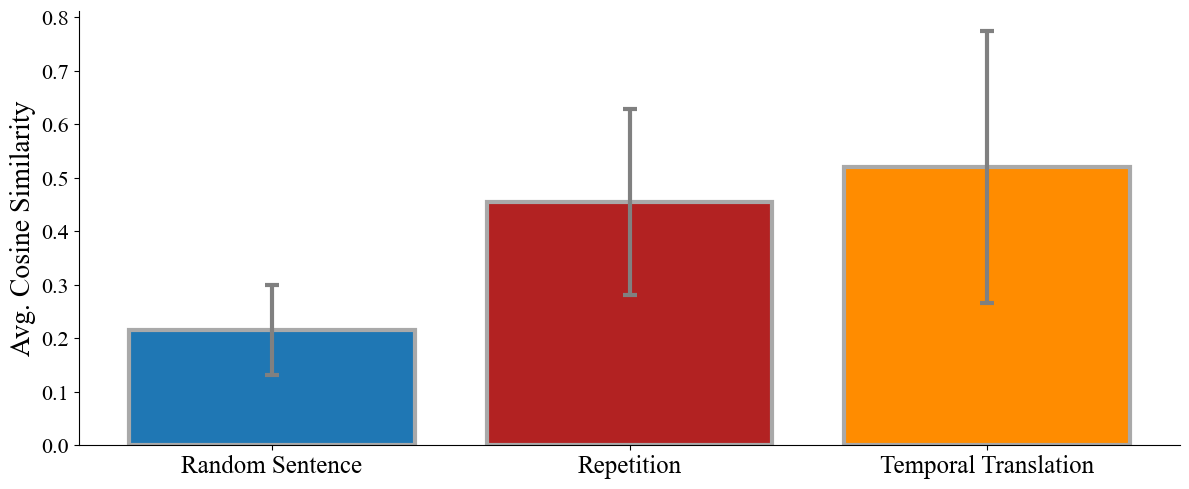

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load and filter data
steering_res = pd.read_csv("SteeringResults.csv", delimiter=";")
steering_res = steering_res[~steering_res["Model"].isna()]
df_filtered = steering_res.dropna(subset=['SR (filtered, strict)'])

# Define mappings
tasks = ['Random', 'Repetition', 'Translate']
task_map = {"Random": "Random Sentence", "Repetition": "Repetition", "Translate": "Temporal Translation"}

# Aggregate data
task_means = []
task_stds = []

for task in tasks:
    ts_values = []
    # Loop over all model-target combinations
    for model in df_filtered['Model'].unique():
        for target in df_filtered['Target'].unique():
            subset = df_filtered[
                (df_filtered["Model"] == model) &
                (df_filtered["Task"] == task) &
                (df_filtered["Target"] == target)
            ]
            if subset.empty:
                continue
            best_method = subset[subset["SR (filtered, strict)"] == subset["SR (filtered, strict)"].max()].iloc[0]
            ts_values.append(best_method["TS (filtered)"])
    # Store mean and std
    task_means.append(np.mean(ts_values))
    task_stds.append(np.std(ts_values))

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

x_pos = np.arange(len(tasks))
bar_colors = ["tab:blue", "firebrick", "darkorange"]
bar_edge_colors = ["cornflowerblue","darkred","sandybrown"]
bar_edge_colors = ["darkgray","darkgray","darkgray"]

bars = ax.bar(
    x_pos,
    task_means,
    yerr=task_stds,  # Error bars (optional)
    capsize=5,
    color=bar_colors,
    edgecolor=bar_edge_colors,
    error_kw=dict(ecolor='grey', lw=3, capsize=5, capthick=3)
)
for bar in bars:
    bar.set_linewidth(3)

# Axis labels and title
ax.set_xticks(x_pos)
ax.set_xticklabels([task_map[t] for t in tasks], fontproperties=times_18)
yticks = ax.get_yticklabels()
for label in yticks:
    label.set_fontproperties(times_16)
ax.set_ylabel("Avg. Cosine Similarity", fontproperties=times_20) #, fontweight="bold")

plt.tight_layout()
plt.show()
plt.tight_layout()
fig.savefig("plots/plots_for_paper/topic_shift_avg.pdf")

### Activation Norm per Model and Task

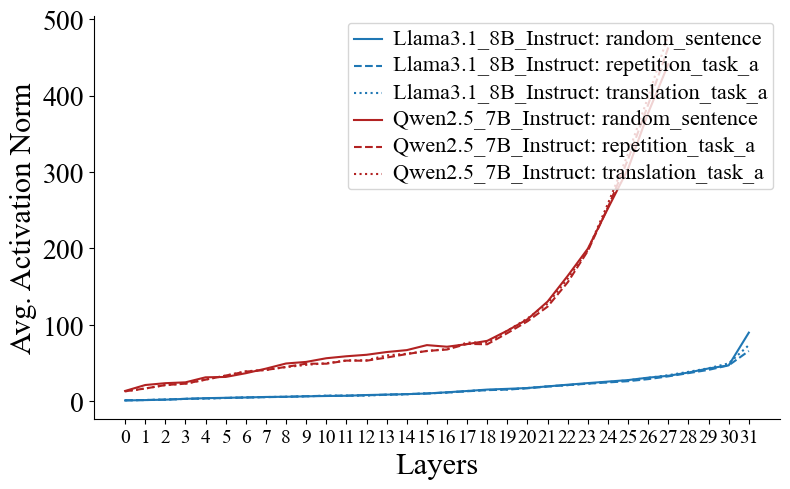

In [ ]:
import pickle
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

model_map = {"llama3.1_8b_instruct":"Llama3.1_8B_Instruct",
                 "qwen2.5_7b_instruct": "Qwen2.5_7B_Instruct"}

task_map = {"random_sentence": "Random Sentence",
            "translation_task_a": "Temporal Translation",
            "repetition_task_a": "Repetition"}

for model_name, color in zip(["llama3.1_8b_instruct", "qwen2.5_7b_instruct"], ["tab:blue", "firebrick"]):

    

    for task, linestyle in zip(["lda_steering", "repetition_task_a", "translation_task_a"], ["-","--", ":"]):
        taskname = task_map[task]

        try:
            with open(f"results/{model_name}/steering_experiments/{task}/layer_norm_last.pkl", "rb") as f:
                activation_norms = pickle.load(f)

            layers = [l.split("_")[1] for l in list(activation_norms.keys())]
            norms = list(activation_norms.values())

            plt.plot(layers, norms, label=f"{model_map[model_name]}: {taskname}", color=color, linestyle=linestyle)

        except FileNotFoundError:
            print(f"results/{model_name}/steering_experiments/{task_map[task]}/layer_norm_last.pkl")
            continue


#plt.xticks(rotation=90)

plt.xticks(fontproperties=times_14)
plt.yticks(fontproperties=times_20)

plt.ylabel("Avg. Activation Norm", fontproperties=times_22)
plt.xlabel("Layers", fontproperties=times_22)

leg = plt.legend(loc="upper right")
for text in leg.get_texts():
    text.set_fontproperties(times_16)
plt.tight_layout()
plt.show()
fig.savefig(
            f"plots/plots_for_paper/norm_per_task.pdf", format="pdf", bbox_inches="tight"
        )